<a href="https://colab.research.google.com/github/sergiolitwiniuk85/nlp/blob/main/nlp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1: Classificaton Fine-tuning

In [1]:
# Librerías

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

import torch
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs available:", torch.cuda.device_count())

from time import time
from datasets import *
from transformers import *
from sklearn.metrics import *
import matplotlib.pyplot as plt

Is CUDA available: True
CUDA version: 12.4
Number of GPUs available: 1


GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


In [11]:
from datasets import config
import os

cache_dir = config.HF_DATASETS_CACHE
print(f"La carpeta de caché de datasets es: {cache_dir}")

# Verifica si la carpeta existe
if os.path.exists(cache_dir):
    print("La carpeta de caché existe.")
else:
    print("La carpeta de caché NO existe, lo cual es inusual si ya intentaste cargar datasets.")

La carpeta de caché de datasets es: /root/.cache/huggingface/datasets
La carpeta de caché existe.


In [12]:
os.environ["WANDB_DISABLED"] = "true"

In [3]:
import shutil
import os
from datasets import config

cache_dir = config.HF_DATASETS_CACHE

if os.path.exists(cache_dir):
    print(f"Deleting the cache directory: {cache_dir}")
    shutil.rmtree(cache_dir)
    print("Cache successfully deleted.")
else:
    print("Cache directory does not exist, nothing to delete.")

# Optional: Verify it's gone
if not os.path.exists(cache_dir):
    print("Verification: Cache directory no longer exists.")


!pip install --upgrade datasets huggingface-hub

Cache directory does not exist, nothing to delete.
Verification: Cache directory no longer exists.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.12

## Dataset

El split **MNLI** del dataset **GLUE** consiste en un par de oraciones (premisa e hipótesis) y una etiqueta indicando la relación entre ellas:

- _Entailment_: La hipótesis es una conclusión lógica de la premisa.
- _Neutral_: La hipótesis no puede ser determinada como verdadera o falsa basada en la premisa.
- _Contradiction_: La hipótesis contradice la premisa.

Además, este split contiene diferentes subconjuntos. Principalmente, usaremos el de _train_ para entrenar y los de _validation_ para evaluar la calidad del modelo. Los de _test_ los omitiremos para este trabajo.
- _Train_: Dataset que usaremos para entrenar el modelo.
- _MNLI-matched_ (MNLI-m): Dataset de validación creado a partir de las mismas categorías de los del conjunto de entrenamiento (e.g., noticias, ficción).
- _MNLI-mismatched_ (MNLI-mm): Dataset de validación creado a partir de diferentes categorías de los del conjunto de entrenamiento (e.g., discursos políticos, cartas).

Aquí la ficha del dataset para que podáis explorarla: https://huggingface.co/datasets/nyu-mll/glue

In [4]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

dataset = load_dataset("glue", "mnli")
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

Con el único motivo de no demorar los tiempos de entrenamiento. Filtraremos el dataset y nos quedaremos solo con los registros que tenga longitud del campo _premise_ inferior a 20.

El resto de la práctica se pide trabajarla sobre la variable `ds_tarea`.

In [5]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def filter_rows(x):
    return len(x['premise'])<20
ds_tarea = dataset.filter(filter_rows)

assert len(ds_tarea['train']) == 13635
assert len(ds_tarea['validation_matched']) == 413
assert len(ds_tarea['validation_mismatched']) == 296

ds_tarea

Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 288
    })
})

## Modeling

En este apartado es donde tendréis que realizar todo el trabajo de la práctica. El formato, el análisis, el modelo escogido y cualquier proceso intermedio que consideréis es totalmente libre. Sin embargo, hay algunas pautas que tendréis que cumplir:

- La variable `model_checkpoint` debe almacenar el nombre del modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `model` y la variable `tokenizer` almacenarán, respectivamente, el modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `trainer` almacenará el _Trainer_ de 🤗 que, en la siguiente sección utilizaréis para entrenar el modelo.
- Debe existir una función llamada `preprocess_function` que realice la tokenización y, si lo consideráis oportuno, transformaciones de las _features_.

Nota: En el _tokenizer_, es obligatorio que el argumento `padding` sea distinto de `False` y que su salida sean **tensores** de pytorch.

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

model_checkpoint = "bert-base-uncased" #uso el bert-base-uncased, un modelo encoder por naturaleza
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3) #uso automodel y autotokenizer para traer las conf del mismo checkpoint

def preprocess_function(x):
    return tokenizer(
        x['premise'],
        x['hypothesis'],
        truncation=True,
        padding='longest',
        max_length=512,
        return_tensors="pt")

# Aplicamos la tokenización a todos los datasets
tokenized_datasets = ds_tarea.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(  #padding dinamico
    tokenizer=tokenizer,
    padding=True,
    return_tensors="pt"
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)  #logits a prediccion de clases

    # calculo de metricas
    acc = accuracy_score(labels, predictions)
    pre = precision_score(labels, predictions, average=None, zero_division=0)  # Precision por clase
    rec = recall_score(labels, predictions, average=None, zero_division=0)    # Recall por clase

    # Devolvemos un diccionario con todas las métricas
    return {
        "accuracy": acc,
        "precision_0": pre[0],
        "precision_1": pre[1],
        "precision_2": pre[2],
        "recall_0": rec[0],
        "recall_1": rec[1],
        "recall_2": rec[2],
    }

training_args = TrainingArguments(
    output_dir="./results",
    run_name="mnli-bert-tarea-NLP-1",
    eval_strategy="epoch",  # Evaluar al final de cada época
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  #metrica clave
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation_matched"],  # evaluación manual para mismatched
    data_collator=data_collator,
    tokenizer=tokenizer,
    #compute_metrics=compute_metrics,  #fn de metricas
)



loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.53.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file tokenizer.json from cache at /root/.cache/

Map:   0%|          | 0/13635 [00:00<?, ? examples/s]

Map:   0%|          | 0/413 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-13-960640971.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training

In [14]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

start = time()

trainer.train()

end = time()
print(f">>>>>>>>>>>>> elapsed time: {(end-start)/60:.0f}m")

The following columns in the Training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, premise, hypothesis. If idx, premise, hypothesis are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 13,635
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2,559
  Number of trainable parameters = 109,484,547


Epoch,Training Loss,Validation Loss
1,0.866000,0.547982


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, premise, hypothesis. If idx, premise, hypothesis are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 413
  Batch size = 16


KeyError: "The `metric_for_best_model` training argument is set to 'eval_accuracy', which is not found in the evaluation metrics. The available evaluation metrics are: ['eval_loss']. Consider changing the `metric_for_best_model` via the TrainingArguments."

## Evaluation

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

print(f"**** EVALUACIÓN ****")
print(f"********\nTokenizer config:\n{tokenizer}")
print(f"\n\n********\nModel config:\n{model.config}")
print(f"\n\n********\nTrainer arguments:\n{trainer.args}")

**** EVALUACIÓN ****
********
Tokenizer config:
BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


********
Model config:
BertConfig {
  "architectures": [
    "BertForSequenc

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

sample = ds_tarea['validation_matched'][0]
inputs = preprocess_function(sample)
for key, value in inputs.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} es una instancia de torch.Tensor")
    else:
        print(f"{key} no es una instancia de torch.Tensor")

input_ids es una instancia de torch.Tensor
token_type_ids es una instancia de torch.Tensor
attention_mask es una instancia de torch.Tensor


In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict(x):
    inputs = preprocess_function(x)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        return {'prediction': predictions.item()}

ds_predictions = ds_tarea.map(predict)

assert len(ds_predictions['train']) == 13635
assert len(ds_predictions['validation_matched']) == 413
assert len(ds_predictions['validation_mismatched']) == 296

ds_predictions

Map:   0%|          | 0/13635 [00:00<?, ? examples/s]

Map:   0%|          | 0/413 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 288
    })
})

*** train ***


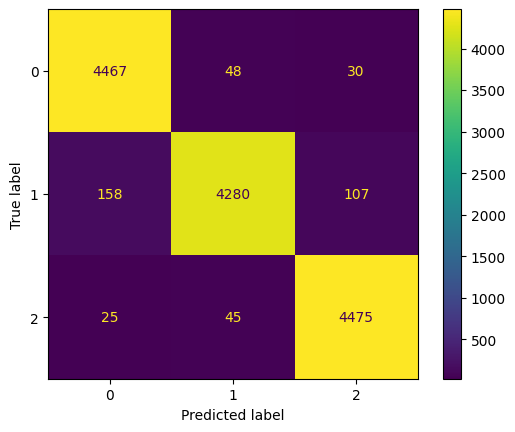

*** validation_matched ***


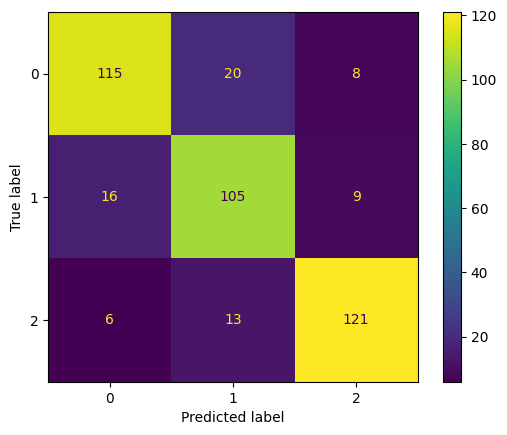

*** validation_mismatched ***


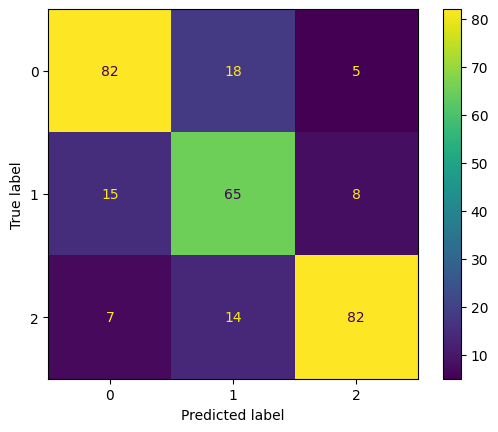

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print(f"*** {subset} ***")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

metrics = {}
for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    pre = precision_score(y_true=y_true, y_pred=y_pred, average=None)
    rec = recall_score(y_true=y_true, y_pred=y_pred, average=None)
    metrics[subset] = [acc] + pre.tolist() + rec.tolist()
    print(f"Subset: {subset}:")
    print(f"Accuracy: {acc:.2f} | Precision0: {pre[0]:.2f} | Precision1: {pre[1]:.2f} | Precision2: {pre[2]:.2f} | Recall0: {rec[0]:.2f} | Recall1: {rec[1]:.2f} | Recall2: {rec[2]:.2f}")
    print("-----\n")

Subset: train:
Accuracy: 0.97 | Precision0: 0.96 | Precision1: 0.98 | Precision2: 0.97 | Recall0: 0.98 | Recall1: 0.94 | Recall2: 0.98
-----

Subset: validation_matched:
Accuracy: 0.83 | Precision0: 0.84 | Precision1: 0.76 | Precision2: 0.88 | Recall0: 0.80 | Recall1: 0.81 | Recall2: 0.86
-----

Subset: validation_mismatched:
Accuracy: 0.77 | Precision0: 0.79 | Precision1: 0.67 | Precision2: 0.86 | Recall0: 0.78 | Recall1: 0.74 | Recall2: 0.80
-----

